faccio un modello lo addestro poi lo copio varie volte e poi faccio un pruning interno copy.deepcopy(model)

In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import copy
from torch.nn.parameter import Parameter
from Spectral_Layer import Spectral
from pruning_functions import BaseModel, evaluate, fit, LinearForPruning
from tqdm import trange

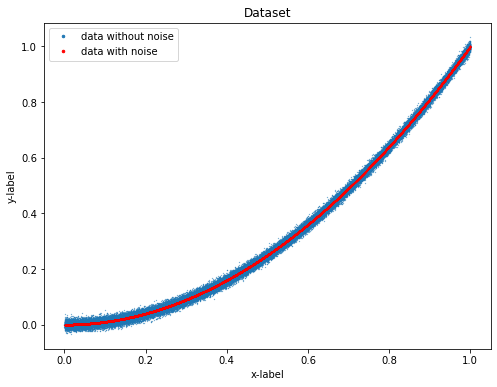

In [2]:
alpha = 2. 
sigma = 0.01
size = 70000

x = np.linspace(0, 1, size)
z = np.random.normal(0, sigma, size)  # noise
t = x**alpha
y = t + z   # add noise

X = []
Y = []
for i in range(size):
    X.append([x[i]])
    Y.append([y[i]])
    
X = np.array(X)
Y = np.array(Y)

plt.figure (figsize = (8, 6))
plt.plot(X, Y, marker='.', linestyle = '', label='data without noise', markersize=0.5)
plt.plot(x, t, marker='.', linestyle='', color='red', label='data with noise', markersize=0.5)
plt.title('Dataset')
plt.legend(markerscale=10.)
plt.xlabel('x-label')
plt.ylabel('y-label')
plt.show()

In [3]:
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader
from torch.utils.data import random_split

X = torch.from_numpy(X)
Y = torch.from_numpy(Y)

# Define dataset
dataset = TensorDataset(X, Y)
train_ds, val_ds, test_ds = random_split(dataset, [50000, 10000, 10000])

# Define data loader
batch_size = 1500
train_dl = DataLoader(train_ds, batch_size, shuffle=True)
val_dl = DataLoader(val_ds, batch_size)
test_dl = DataLoader(test_ds, batch_size)

In [4]:
# Regression model for spectral pruning
config = {'base_grad' : False,
         'start_grad' : True,
         'end_grad' : True,
         'bias': False}

class PruningRegressionSpectral(BaseModel):
    def __init__(self):
        super().__init__()
        self.spectralin = Spectral(1, 200, **config)
        self.spectral1 = Spectral(200, 200, **config)
        self.spectralout = Spectral(200, 1, **config)
    
    def forward(self,x):
        out = self.spectralin(x)  # Imput: first linear transformation
        out = self.spectral1(out) # Linear transformation
        out = F.elu(out)   # Non linear filter
        out = self.spectralout(out)  # Last linear transformation: output
        return out
    
    
    def pruning_spectral(self,
                    perc: float,
                    start_grad: bool = False, 
                    end_grad: bool = False, 
                    base_grad: bool = True):
        
        self.spectralin.pruning_diag(perc, start_grad, end_grad, base_grad)
        self.spectral1.pruning_diag(perc, start_grad, end_grad, base_grad)
        self.spectralout.pruning_diag(perc, start_grad, end_grad, base_grad)
        
   
        
pruning_model_spectral = PruningRegressionSpectral()

In [5]:
# Regression model for classical pruning
config = {'bias': False}

class PruningRegressionClassical(BaseModel):
    def __init__(self):
        super().__init__()
        self.classicalin = LinearForPruning(1, 200, **config)
        self.classical1 = LinearForPruning(200, 200, **config)
        self.classicalout = LinearForPruning(200, 1, **config)
    
    def forward(self,x):
        out = self.classicalin(x)  # Imput: first linear transformation
        out = self.classical1(out) # Linear transformation
        out = F.elu(out)   # Non linear filter
        out = self.classicalout(out)  # Last linear transformation: output
        return out
    
    
    def pruning_classical(self,
                    perc: float,
                    grad: bool = False):
        
        self.classicalin.prune(perc, grad)
        self.classical1.prune(perc, grad)
        self.classicalout.prune(perc, grad)
        
   
        
pruning_model_classical = PruningRegressionClassical()

In [6]:
# Pre train of spectral principal model 
args = {'lr': 0.01,
       'model': pruning_model_spectral,
       'train_loader': train_dl,
       'val_loader': val_dl,
       'opt_func': torch.optim.Adam}

history_principal_spectral, result_principal_spectral = fit(20, **args)

# Pre train of classical principal model 
args = {'lr': 0.01,
       'model': pruning_model_classical,
       'train_loader': train_dl,
       'val_loader': val_dl,
       'opt_func': torch.optim.Adam}

history_principal_classical, result_principal_classical = fit(20, **args)

Epoch 0:   0%|          | 0/20 [00:00<?, ?epochs/s] 

Epoch [19], val_loss: 0.000220, val_MAE: 0.012091, val_RMSE: 0.0148278


Epoch 19: 100%|██████████| 20/20 [00:15<00:00,  1.31epochs/s, loss=0.000264]

Epoch [19], val_loss: 0.000280, val_MAE: 0.013386, val_RMSE: 0.0167364


In [7]:
cuts = [x for x in range(101) if x%5==0] # All multiples of 5 from 0 to 5
#cuts = [50, 75]

model_s = []
model_c = []

args_s = {'start_grad': True,
        'end_grad': True,
        'base_grad': True}

args_c = {'grad': True}

for i in range(len(cuts)):
    model_s.append(copy.deepcopy(pruning_model_spectral))
    model_c.append(copy.deepcopy(pruning_model_classical))
for i in range(len(cuts)):
    model_s[i].pruning_spectral(perc=cuts[i], **args_s)
    model_c[i].pruning_classical(perc=cuts[i], **args_c)
    

In [8]:
history_s = []
result_s = []
for i in range(len(cuts)):
    args_s = {'lr': 0.01,
              'model': model_s[i],
              'train_loader': train_dl,
              'val_loader': val_dl,
              'opt_func': torch.optim.Adam}
    print('Model: model_s',i)
    h, r = fit(20, **args_s)
    history_s.append(h)
    result_s.append(r)

Epoch 0:   0%|          | 0/20 [00:00<?, ?epochs/s] 

Model: model_s 0


Epoch 0:   0%|          | 0/20 [00:00<?, ?epochs/s] 

Epoch [19], val_loss: 0.000321, val_MAE: 0.014756, val_RMSE: 0.0179064
Model: model_s 1


Epoch 0:   0%|          | 0/20 [00:00<?, ?epochs/s] 

Epoch [19], val_loss: 0.000321, val_MAE: 0.014787, val_RMSE: 0.0179092
Model: model_s 2


Epoch 0:   0%|          | 0/20 [00:00<?, ?epochs/s] 

Epoch [19], val_loss: 0.000323, val_MAE: 0.014626, val_RMSE: 0.0179602
Model: model_s 3


Epoch 0:   0%|          | 0/20 [00:00<?, ?epochs/s] 

Epoch [19], val_loss: 0.000319, val_MAE: 0.014682, val_RMSE: 0.0178652
Model: model_s 4


Epoch 0:   0%|          | 0/20 [00:00<?, ?epochs/s] 

Epoch [19], val_loss: 0.000320, val_MAE: 0.014740, val_RMSE: 0.0178906
Model: model_s 5


Epoch 0:   0%|          | 0/20 [00:00<?, ?epochs/s] 

Epoch [19], val_loss: 0.000317, val_MAE: 0.014672, val_RMSE: 0.0177988
Model: model_s 6


Epoch 0:   0%|          | 0/20 [00:00<?, ?epochs/s] 

Epoch [19], val_loss: 0.000334, val_MAE: 0.015015, val_RMSE: 0.0182757
Model: model_s 7


Epoch 0:   0%|          | 0/20 [00:00<?, ?epochs/s] 

Epoch [19], val_loss: 0.000334, val_MAE: 0.014939, val_RMSE: 0.0182625
Model: model_s 8


Epoch 0:   0%|          | 0/20 [00:00<?, ?epochs/s] 

Epoch [19], val_loss: 0.000345, val_MAE: 0.015199, val_RMSE: 0.0185693
Model: model_s 9


Epoch 0:   0%|          | 0/20 [00:00<?, ?epochs/s] 

Epoch [19], val_loss: 0.000329, val_MAE: 0.014880, val_RMSE: 0.0181504
Model: model_s 10


Epoch 0:   0%|          | 0/20 [00:00<?, ?epochs/s] 

Epoch [19], val_loss: 0.000223, val_MAE: 0.012189, val_RMSE: 0.0149304
Model: model_s 11


Epoch 0:   0%|          | 0/20 [00:00<?, ?epochs/s] 

Epoch [19], val_loss: 0.000323, val_MAE: 0.014757, val_RMSE: 0.0179648
Model: model_s 12


Epoch 0:   0%|          | 0/20 [00:00<?, ?epochs/s] 

Epoch [19], val_loss: 0.000330, val_MAE: 0.014945, val_RMSE: 0.0181598
Model: model_s 13


Epoch 0:   0%|          | 0/20 [00:00<?, ?epochs/s] 

Epoch [19], val_loss: 0.000233, val_MAE: 0.012191, val_RMSE: 0.0152668
Model: model_s 14


Epoch 0:   0%|          | 0/20 [00:00<?, ?epochs/s] 

Epoch [19], val_loss: 0.000252, val_MAE: 0.012751, val_RMSE: 0.015864
Model: model_s 15


Epoch 0:   0%|          | 0/20 [00:00<?, ?epochs/s] 

Epoch [19], val_loss: 0.000258, val_MAE: 0.012776, val_RMSE: 0.0160729
Model: model_s 16


Epoch 0:   0%|          | 0/20 [00:00<?, ?epochs/s] 

Epoch [19], val_loss: 0.000333, val_MAE: 0.014419, val_RMSE: 0.0182365
Model: model_s 17


Epoch 0:   0%|          | 0/20 [00:00<?, ?epochs/s] 

Epoch [19], val_loss: 0.000287, val_MAE: 0.013995, val_RMSE: 0.0169393
Model: model_s 18


Epoch 0:   0%|          | 0/20 [00:00<?, ?epochs/s] 

Epoch [19], val_loss: 0.000883, val_MAE: 0.024757, val_RMSE: 0.0297196
Model: model_s 19


Epoch 0:   0%|          | 0/20 [00:00<?, ?epochs/s] 

Epoch [19], val_loss: 0.000291, val_MAE: 0.013486, val_RMSE: 0.0170608
Model: model_s 20


Epoch 19: 100%|██████████| 20/20 [00:16<00:00,  1.24epochs/s, loss=0.000335]

Epoch [19], val_loss: 0.000261, val_MAE: 0.013163, val_RMSE: 0.0161633


In [9]:
t_c = [evaluate(model_c[i], test_dl) for i in range(len(cuts))]
t_s = [evaluate(model_s[i], test_dl) for i in range(len(cuts))]

test_c_loss = [t_c[i]['val_loss'] for i in range(len(cuts))]
test_s_loss = [t_s[i]['val_loss'] for i in range(len(cuts))]
test_c_mae = [t_c[i]['val_MAE'] for i in range(len(cuts))]
test_s_mae = [t_s[i]['val_MAE'] for i in range(len(cuts))]
test_c_rmse = [t_c[i]['val_RMSE'] for i in range(len(cuts))]
test_s_rmse = [t_s[i]['val_RMSE'] for i in range(len(cuts))]

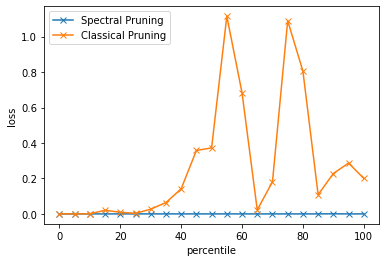

In [10]:
plt.plot(cuts,test_s_loss, '-x', label='Spectral Pruning')
plt.plot(cuts,test_c_loss, '-x', label='Classical Pruning')
plt.xlabel('percentile')
plt.ylabel('loss')
plt.legend()

plt.show()

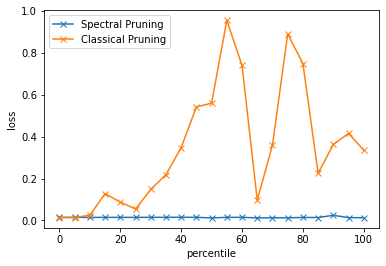

In [11]:
plt.plot(cuts,test_s_mae, '-x', label='Spectral Pruning')
plt.plot(cuts,test_c_mae, '-x', label='Classical Pruning')
plt.xlabel('percentile')
plt.ylabel('loss')
plt.legend()

plt.show()

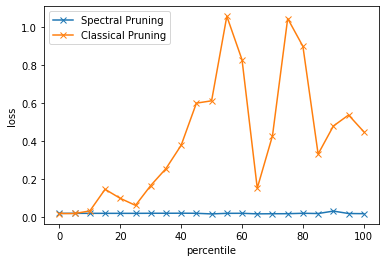

In [12]:
plt.plot(cuts,test_s_rmse, '-x', label='Spectral Pruning')
plt.plot(cuts,test_c_rmse, '-x', label='Classical Pruning')
plt.xlabel('percentile')
plt.ylabel('loss')
plt.legend()

plt.show()

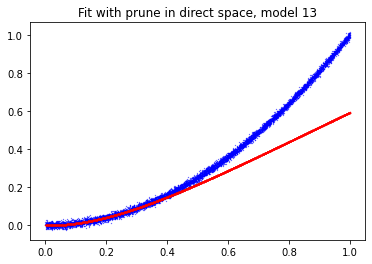

In [26]:
x_test, y_test = test_ds[:] 
y_classical = model_c[13](x_test)

plt.plot(x_test, y_test, color='blue', linestyle='', marker='.', label='data', markersize=0.5)
plt.plot(x_test, y_classical.detach(), color='red', linestyle='', marker='.', label='fit', markersize=0.5)
plt.title('Fit with prune in direct space, model 13')
plt.show()

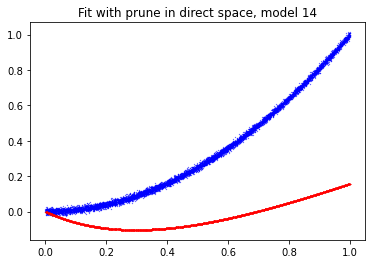

In [27]:
x_test, y_test = test_ds[:] 
y_classical = model_c[14](x_test)

plt.plot(x_test, y_test, color='blue', linestyle='', marker='.', label='data', markersize=0.5)
plt.plot(x_test, y_classical.detach(), color='red', linestyle='', marker='.', label='fit', markersize=0.5)
plt.title('Fit with prune in direct space, model 14')
plt.show()

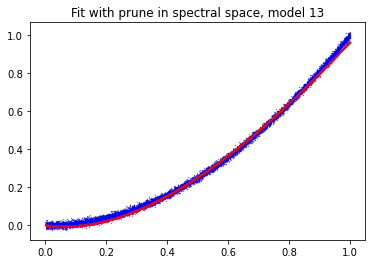

In [28]:
x_test, y_test = test_ds[:] 
y_classical = model_s[13](x_test)

plt.plot(x_test, y_test, color='blue', linestyle='', marker='.', label='data', markersize=0.5)
plt.plot(x_test, y_classical.detach(), color='red', linestyle='', marker='.', label='fit', markersize=0.5)
plt.title('Fit with prune in spectral space, model 13')
plt.show()